<a href="https://colab.research.google.com/github/joaxkal/SDM/blob/master/LSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDM PA#3 LSH

In [0]:
import os
import numpy as np

## 1. DATA PREPROCESSING

#### Downloading data from FMA repo

In [2]:
os.system('curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip')

0

#### Unziping downloaded data

In [3]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "fma_metadata.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zipf: 

    # extracting all the files 
    print('Extracting all the files now...') 
    zipf.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


#### Read data  as csv and remove NaN values

In [4]:
#read data
import pandas as pd
features = pd.read_csv("fma_metadata/features.csv", header =[0,1,2],index_col=0)
genres = pd.read_csv("fma_metadata/genres.csv", index_col=0)
tracks = pd.read_csv("fma_metadata/tracks.csv", header =[0,1],index_col=0)
print(features.shape)
print(tracks.shape)
print(genres.shape)

(106574, 518)
(106574, 52)
(163, 4)


In [5]:
#drop nan 
idx=tracks.iloc[:, tracks.columns.get_level_values(1)=='genre_top'].iloc[:,0].notna()
tracks = tracks[idx]
features = features[idx]
print(tracks.shape) 
print(features.shape) 

(49598, 52)
(49598, 518)


####  Presentin first few rows from each dataframe

In [6]:
features.head()

feature    chroma_cens                      ...  zcr                    
statistics    kurtosis                      ...  min      skew       std
number              01        02        03  ...   01        01        01
track_id                                    ...                         
2             7.180653  5.230309  0.249321  ...  0.0  2.089872  0.061448
3             1.888963  0.760539  0.345297  ...  0.0  1.716724  0.069330
5             0.527563 -0.077654 -0.279610  ...  0.0  2.193303  0.044861
10            3.702245 -0.291193  2.196742  ...  0.0  3.542325  0.040800
134           0.918445  0.674147  0.577818  ...  0.0  1.806106  0.054623

[5 rows x 518 columns]

In [7]:
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


In [8]:
tracks.head(1)

album                       ... track      
         comments         date_created  ...  tags title
track_id                                ...            
2               0  2008-11-26 01:44:45  ...    []  Food

[1 rows x 52 columns]

#### Standardize features data using StandardScaler

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features.values), columns=features.columns, index=features.index)
features.describe()

feature      chroma_cens                ...           zcr              
statistics      kurtosis                ...          skew           std
number                01            02  ...            01            01
count       4.959800e+04  4.959800e+04  ...  4.959800e+04  4.959800e+04
mean        1.308286e-17  2.948218e-17  ...  3.674695e-16  1.731951e-16
std         1.000010e+00  1.000010e+00  ...  1.000010e+00  1.000010e+00
min        -3.150893e-01 -3.133115e-01  ... -6.435446e+00 -1.431306e+00
25%        -1.211300e-01 -1.179114e-01  ... -5.940109e-01 -6.676304e-01
50%        -5.414282e-02 -5.070875e-02  ... -2.560083e-01 -2.622763e-01
75%         4.249670e-02  4.485217e-02  ...  2.820694e-01  3.948981e-01
max         2.099264e+02  2.142404e+02  ...  2.494083e+01  1.414008e+01

[8 rows x 518 columns]

#### Select g most genres from the dataset to be used for the classification task
#### MAX g = 16 as there are 16 genres_top in the dataset

In [0]:
copy_features = features.copy()
copy_tracks = tracks.copy()

In [11]:
g = 10 # number of genres


genres = copy_tracks['track', 'genre_top'].values
genres, count = np.unique(genres, return_counts=True)
count_sort_ind = np.argsort(-count)
genres = genres[count_sort_ind]
genres = genres[:g]
features = copy_features[copy_tracks['track', 'genre_top'].isin(genres)]
tracks = copy_tracks[copy_tracks['track', 'genre_top'].isin(genres)]
print(genres)
print(tracks.shape) 
print(features.shape) 

['Rock' 'Experimental' 'Electronic' 'Hip-Hop' 'Folk' 'Pop' 'Instrumental'
 'International' 'Classical' 'Jazz']
(48118, 52)
(48118, 518)


In [12]:
x_train = features[tracks['set','split']=='training'].values
id_train = features.index.values
genre_train = tracks[tracks['set','split']=='training']['track', 'genre_top'].values
x_validation = features[tracks['set','split']=='validation'].values
genre_validation = tracks[tracks['set','split']=='validation']['track', 'genre_top'].values
x_test = features[tracks['set','split']=='test'].values
genre_test = tracks[tracks['set','split']=='test']['track', 'genre_top'].values

print("train:       |", str(x_train.shape), str(genre_train.shape),
      "\nvalidation:  |",str(x_validation.shape) ,str(genre_validation.shape),
      "\ntest:        |",str(x_test.shape) ,str(genre_test.shape))

train:       | (38847, 518) (38847,) 
validation:  | (4486, 518) (4486,) 
test:        | (4785, 518) (4785,)


## 2. ALGORITHM IMPLEMENTATION

#### Achtiopas distribution used for Random Projection

In [13]:
def achlioptas(size):
  choices =   ([-np.sqrt(3)] + [0] * 4 + [np.sqrt(3)])
  return np.random.choice(choices, (size))

#test
achlioptas((3,3))

array([[ 0.        , -1.73205081,  0.        ],
       [ 0.        ,  1.73205081,  0.        ],
       [ 1.73205081,  0.        ,  0.        ]])

#### HashTable implementation. 
LSH uses multiple hash tables.

In [0]:
import numpy as np
    
class HashTable:
    def __init__(self, hash_size, inp_dimensions):
        self.hash_size = hash_size
        self.inp_dimensions = inp_dimensions
        self.hash_table = dict()
        self.projections = achlioptas((self.hash_size, inp_dimensions))
        
    def generate_hash(self, inp_vector):
        bools = (np.dot(inp_vector, self.projections.T) > 0).astype('int')
        hash_values = [''.join(row) for row in bools.astype('str')]
        return hash_values

    def __setitem__(self, inp_vec, labels):
        hash_values = self.generate_hash(inp_vec)
        for hash_value, label in zip(hash_values,labels):
          self.hash_table[hash_value] = self.hash_table\
              .get(hash_value, list()) + [label]
        
    def __getitem__(self, inp_vec):
        hash_values = self.generate_hash(inp_vec)
        results = [self.hash_table.get(hash_value, []) for hash_value in hash_values]
        return results

### LSH Implementation

In [0]:
class LSH:
    def __init__(self, num_tables, hash_size, k_nn, sim_measure='cos_sim'):
        """
          num_tables: n : number of hash tables
          hash_size:  l : length of hash 
                        [number of possible hash bucekts is equal to 2^l]
          k_nn:       k : number of nearest neighbours used in selecting the genre
          sim_measure:  : "cos_sim" OR "euclid_dist"
                          similarity measure used to sort the tracks that 
                          are selected as simillar by LSH 
                          (accual similairt measure for tracks that 
                          fell into the same hash backet) 
        """
        self.num_tables = num_tables
        self.hash_size = hash_size
        self.inp_dimensions = x_train.shape[1]
        self.sim_measure = sim_measure
        self.k = k_nn
        self.hash_tables = list()
        for i in range(self.num_tables):
            self.hash_tables.append(HashTable(self.hash_size, self.inp_dimensions))

    def calc_sim(self, a, b, sim_measure):

        if sim_measure == 'cos_sim':
          dot_product = np.dot(a, b.T)

          if a.ndim > 1:
            norm_a = np.linalg.norm(a, axis=1)
          else:
            norm_a = np.linalg.norm(a)
          if b.ndim > 1:
            norm_b = np.linalg.norm(b, axis=1)
          else:
            norm_b = np.linalg.norm(b)
          
          norm_a = np.expand_dims(norm_a, axis=1)
          norm_b = np.expand_dims(norm_b, axis=1)
          sim = dot_product / np.dot(norm_a , norm_b.T)
          return sim.T

        else:
          """Takes 2 vectores a, b and returns the euclidian distance 
          between them
          """
          a = np.repeat(a,b.shape[0], axis=0)
          return np.expand_dims(np.linalg.norm(b, axis=1),axis=1)


    def __setitem__(self, inp_vec, label):
        for table in self.hash_tables:
            table[inp_vec] = label

    def __getitem__(self, inp_vec):
        results = list()
        # get simillar items
        for table in self.hash_tables:
            results.append(table[inp_vec])

        results_by_track = list()
        for j in range(inp_vec.shape[0]):
          results_for_track = list()
          for i in range(self.num_tables):
            results_for_track.extend(results[i][j])
          #append (make into set to discard duplicates coming from different backets)
          results_by_track.append(set(results_for_track))

        #calculate actual similarity using selected similarity measure
        assigned_genre=list()
        for results_for_track, track_vec in zip(results_by_track,inp_vec):
          if len(results_for_track) != 0:
            features_vec = features.loc[results_for_track]
            track_vec = np.expand_dims(track_vec, axis=0)
            similarity = self.calc_sim(track_vec, features_vec, self.sim_measure)
            genres_of_similar_tracks = tracks.loc[results_for_track,['track', 'genre_top']].copy()
            genres_of_similar_tracks['similarity'] = similarity
            genres_of_similar_tracks = genres_of_similar_tracks.sort_values(
                'similarity',
                 ascending = True if self.sim_measure=='euclid_dist' else False)
            genres_of_similar_tracks = genres_of_similar_tracks['track', 'genre_top']
            #vote with k nearest neighbors to get the resulting genre
            k_nn = genres_of_similar_tracks[:self.k]
            # get most frequent genre from the k nn
            assigned_genre.append(k_nn.mode().values[0])
          else:
            # if nothing was hashed to the same bucket 
            # we assign the most common genre to this track
            assigned_genre.append(genres[0])

          #vote with k nearest neighbors to get the resulting genre
        return assigned_genre

## 3. TESTING AND HYPEROPTIMISATION

#### How to use: sumple configuration and classification

In [0]:
# create an instance of LSH class
lsh=LSH(5,10, 3, 'cos_sim') #n=5, l=14, k=3, sim=cos_sim / euc_dist

# fit LSH to training data
lsh[x_train]=id_train

In [23]:
# predict genre for validation data
import time
s=time.time()
pred_genre = lsh[x_validation]
genre_validation = genre_validation
print(time.time() - s)

71.29889154434204


#### Evaluate the results for the sample results

In [24]:
# calculate accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(genre_validation, pred_genre)
print("ACCURACY: " +str(np.round(acc,2)*100) +"%")

ACCURACY: 43.0%


In [25]:
np.unique(genre_validation)

array(['Classical', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop',
       'Instrumental', 'International', 'Jazz', 'Pop', 'Rock'],
      dtype=object)

In [26]:
# calculate precision, recall and f1 score for each class using calssifcation report
from sklearn.metrics import classification_report
print(classification_report(genre_validation, pred_genre,))

               precision    recall  f1-score   support

    Classical       0.17      0.81      0.28        74
   Electronic       0.39      0.60      0.47       871
 Experimental       0.37      0.42      0.39       966
         Folk       0.33      0.35      0.34       229
      Hip-Hop       0.38      0.21      0.27       319
 Instrumental       0.12      0.03      0.04       191
International       0.35      0.12      0.18       137
         Jazz       0.25      0.03      0.06        62
          Pop       0.06      0.00      0.01       313
         Rock       0.68      0.59      0.63      1324

     accuracy                           0.43      4486
    macro avg       0.31      0.32      0.27      4486
 weighted avg       0.43      0.43      0.41      4486



WE WANT THE DIAGONAL VALUES TO BE EQUAL TO 1 AND OTHER VALUES TO BE EQUAL TO 0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


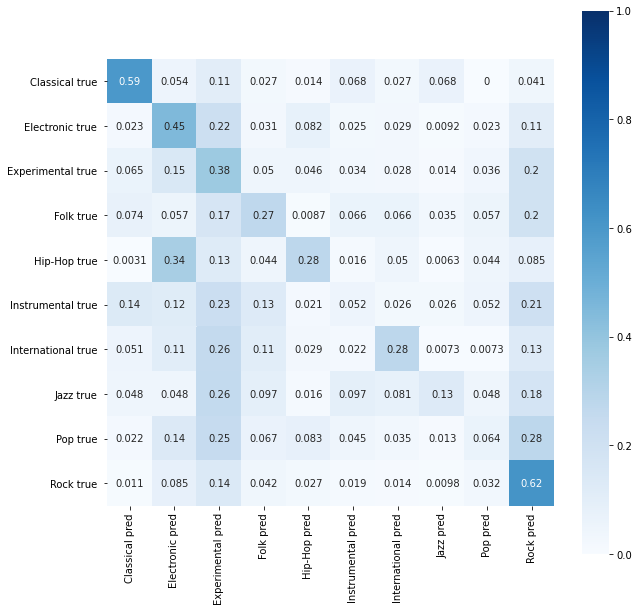

In [21]:
# confusion matrix
#WE WANT THE DIAGONAL VALUES TO BE EQUAL TO 1 AND OTHER VALUES TO BE EQUAL TO 0
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(genre_validation, pred_genre)
genre_labels, true_counts = np.unique(genre_validation, return_counts=True)

#turn counts to percentage 0-100%
cm = cm / np.expand_dims(true_counts,axis=1)

df_cm = pd.DataFrame(cm, index = [i + " true " for i in genre_labels],
                  columns = [i + " pred" for i in genre_labels])
import seaborn as sn
import matplotlib.pyplot as plt
print("WE WANT THE DIAGONAL VALUES TO BE EQUAL TO 1 AND OTHER VALUES TO BE EQUAL TO 0")
plt.figure(figsize=(10,10))
sn.heatmap(df_cm, square=True, vmin=0, vmax=1, annot=True, cmap='Blues')